<a href="https://colab.research.google.com/github/Krankile/npmf/blob/main/notebooks/training_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

##Kernel setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
!pip install wandb
!git clone https://github.com/Krankile/npmf.git

In [3]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


##General setup

In [18]:
%%capture
!cd npmf && git pull

import math
import multiprocessing
import os
import pickle
from collections import Counter, defaultdict
from dataclasses import asdict, dataclass
from datetime import datetime, timedelta
from operator import itemgetter
from typing import Callable, List, Tuple
from functools import partial
from more_itertools import chunked

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from npmf.utils.colors import main, main2, main3
from npmf.utils.dataset import TimeDeltaDataset
from npmf.utils.dtypes import fundamental_types
from npmf.utils.eikon import column_mapping
from npmf.utils.tests.utils import pickle_df
from npmf.utils.wandb import get_datasets, put_dataset
from npmf.utils.training import EarlyStop, to_device, TqdmPostFix, mape_loss

from numpy.ma.core import outerproduct
from pandas.tseries.offsets import BDay, Day
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from torch import nn
from torch.utils.data import DataLoader, Dataset

import wandb as wb

In [5]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[main, main2, main3, "black"])
mpl.rcParams['figure.figsize'] = (6, 4)  # (6, 4) is default and used in the paper

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [7]:
np.random.seed(69)

# Create a Neural network class

In [20]:
class MultivariateNetwork(nn.Module):
    def __init__(self, sf_len, meta_cont_len, meta_cat_len, macro_len, hidden_dim, out_len, **params):
        super().__init__()

        self.lags = nn.Sequential(
            nn.Linear(sf_len, hidden_dim),
            nn.ReLU(),
        )

        self.meta_cont = nn.Sequential(
            nn.Linear(meta_cont_len, hidden_dim),
            nn.ReLU(),
        )

        self.meta_cat = nn.ModuleList([nn.Embedding(l, hidden_dim) for l in meta_cat_len])

        self.macro = nn.Sequential(
            nn.Linear(macro_len, hidden_dim),
            nn.ReLU(),
        )

        self.predict = nn.Sequential(
            nn.Linear(3*hidden_dim + 9*hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, out_len),
        )


    def forward(self, lags, meta_cont, meta_cat, macro):

        lags = self.lags(lags)
        meta_cont = self.meta_cont(meta_cont)
        meta_cat = torch.cat([emb(meta_cat[:, i]) for i, emb in enumerate(self.meta_cat)], dim=1)
        macro = self.macro(macro)

        x = torch.cat((lags, meta_cont, meta_cat, macro), dim=1)
        x = self.predict(x)

        return x


# Get some data

In [9]:
%%capture
names = ["stock-data:final", "fundamental-data:final", "meta-data:final", "macro-data:final"]

stock_df, fundamentals_df, meta_df, macro_df = get_datasets(names=names, project="master")

# Run the loop! (Like Odd-Geir Lademo)

![picture](https://drive.google.com/uc?id=1Y55gFQSi4Baovmi0kUQGhbgGOBTI03E7)


In [10]:
loss_dict = dict(mape=mape_loss)

In [11]:
def get_epoch_loss(model, optimizer, dataloader, loss_dict, device, run_type, config):
    epoch_losses = []
    for stocks_and_fundamentals, meta_cont, meta_cat, macro, target in to_device(dataloader, device):
                optimizer.zero_grad()
                y_pred = model(stocks_and_fundamentals, meta_cont, meta_cat, macro)
    
                loss = loss_dict[config.loss_fn](target, y_pred)
                epoch_losses.append(loss.item())
                if run_type == "train":
                    loss.backward()
                    optimizer.step()
    return epoch_losses

In [12]:
def get_naive_epoch_loss(dataloader, loss_dict, device, config):
    epoch_losses = []
    for stocks_and_fundamentals, meta_cont, meta_cat, macro, target in to_device(dataloader, device):
    
                loss = loss_dict[config.loss_fn](target, torch.ones(target.shape, device=device))
                epoch_losses.append(loss.item())
                
    return epoch_losses

In [22]:
def train_one_era(run, model, optimizer, data_train, data_val, stopper, losses, device, config, pbar):

    for epoch in range(config.max_epochs):
        epoch_losses = dict(train=[], val=[])
        
        pbar.update_postfix({"epoch": epoch})
        for run_type, dataloader in {"train": data_train, "val": data_val}.items():
            model.train(run_type == "train")
            
            epoch_losses[run_type] += get_epoch_loss(model, optimizer, dataloader, loss_dict, device, run_type, config)

            epoch_loss = np.mean(epoch_losses[run_type])
            losses[run_type].append(
                epoch_loss)
            run.log({f"epoch_{run_type}": epoch_loss, "epoch": epoch} )
        pbar.update_postfix({"train_loss": np.mean(epoch_losses["train"]), "val_loss": np.mean(epoch_losses["val"])})

        if run_type == "val" and stopper(epoch_losses["val"]):
            losses["epoch_lens"].append(epoch + 1)
            break
        
        pbar.update_postfix({"triggers": f"{stopper.triggers}/{stopper.patience}"})

    return epoch_losses["train"], epoch_losses["val"]

In [23]:
def train(config, project, entity="krankile", enablewb=True) -> nn.Module:
    
    mode = "online" if enablewb else "online"
    with wb.init(config=config, job_type="training", mode=mode) as run:
        cpus = multiprocessing.cpu_count()

        conf = run.config
        print(conf)
        
        #TODO Define model from string given by conf
        model = MultivariateNetwork(**conf)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=conf.learning_rate)

        stopper = EarlyStop(conf.patience, conf.min_delta)

        date_range = pd.date_range(start=conf.start_date, end=conf.end_date, freq="M")
        n_ranges = len(date_range)
        eras = iter(date_range)
        era = next(eras)

        losses = dict(train=[], val=[], epoch_lens=[])

        val = TimeDeltaDataset(era, conf.training_w, conf.forecast_w, conf.n_reports, stock_df, fundamentals_df, meta_df, macro_df)
        na_percentages = {df_key: [] for df_key in val.na_percentage}
        
        last_date = pd.to_datetime("2018-11-30")
        metric = TimeDeltaDataset(last_date, conf.training_w, conf.forecast_w, conf.n_reports, stock_df, fundamentals_df, meta_df, macro_df)
        metric_loader = DataLoader(metric, conf.batch_size, shuffle=False, num_workers=cpus)
        naive_metric_loss = get_naive_epoch_loss(metric_loader, loss_dict, device, conf)

        pbar = TqdmPostFix(eras, total=(n_ranges-1))
        for i, era in enumerate(pbar):
            pbar.set_description(f"Era {era.date()}")
            
            tra = val
            # TODO Refactor this class to only require the top-level conf once
            val = TimeDeltaDataset(era, conf.training_w, conf.forecast_w, conf.n_reports, stock_df, fundamentals_df, meta_df, macro_df)
            
            for df_key in na_percentages:
                na_percentages[df_key] += [val.na_percentage[df_key]]
            
            run.log({**val.na_percentage, "time":era.date, "era":i} )

            data_train = DataLoader(tra, conf.batch_size, shuffle=True, drop_last=False, num_workers=cpus)
            data_val = DataLoader(val, conf.batch_size, shuffle=False, num_workers=cpus)

            stopper.reset()
            train_losses, val_losses = train_one_era(
                run=run, 
                model=model, 
                optimizer=optimizer, 
                data_train=data_train, 
                data_val=data_val, 
                stopper=stopper,
                losses=losses,
                device=device, 
                config=conf,
                pbar=pbar,
            )
            era_naive = get_naive_epoch_loss(data_val, loss_dict, device, conf)
            metric_loss = get_epoch_loss(model, optimizer, metric_loader, loss_dict, device, None, conf)
            run.log( {"era_train": np.mean(train_losses), "era_val" : np.mean(val_losses), "naive_era_loss":np.mean(era_naive) ,"metric_loss":np.mean(metric_loss),"naive_metric_loss":np.mean(naive_metric_loss), "time":era.date, "era":i})

    return model, losses, na_percentages

In [24]:
def get_params_from_data(stock_df, fundamental_df, meta_df, macro_df, params_human):
    sf_len = params_human["training_w"] + fundamental_df.iloc[:,4:].shape[1]*params_human["n_reports"] - params_human["n_reports"] + 2 #TimeDeltaSet removes n total_assets columns and adds global and local reference columns
    meta_cont_len = 1
    meta_cat_len = np.array([len(meta_df[col].unique()) for col in meta_df.iloc[:,1:] if col != "founding_year"]) + 1
    macro_len = (macro_df.shape[1]-1)*params_human["training_w"]
    
    data_given_params = dict(
        sf_len=sf_len,
        meta_cont_len=meta_cont_len,
        meta_cat_len=meta_cat_len,
        macro_len=macro_len,
        out_len=params_human["forecast_w"]
        
    )
    return data_given_params

In [31]:
params_human = dict(
    n_reports=4,
    training_w=240,
    forecast_w=20,
    loss_fn="mape",
    start_date="2000-12-31",
    end_date="2018-10-31",
)

params_wb = dict(
    hidden_dim=32,
    batch_size=1024,
    max_epochs=50,
    patience=50,
    min_delta=0.0001,
    learning_rate=0.001
)

params_from_data = get_params_from_data(stock_df, fundamentals_df, meta_df, macro_df, params_human)

config = {
    **params_human,
    **params_wb,
    **params_from_data,
}


In [ ]:
enablewb = True
count = None
sweepid = "krankile/master/zyyq6y50"

if sweepid:
    count = 500 # number of runs to execute
    wb.agent(sweepid, partial(train,config=config, project="master-test", entity="krankile", enablewb=enablewb), count=count)

else:
    model, losses, _ = train(config=config, project="master-test", entity="krankile", enablewb=enablewb)

wandb: Agent Starting Run: o2gk855q with config:
wandb: 	batch_size: 509
wandb: 	hidden_dim: 92
wandb: 	learning_rate: 0.001230076664691909
wandb: 	max_epochs: 506
wandb: 	min_delta: 0.128834398032854
wandb: 	patience: 70


{'n_reports': 4, 'training_w': 240, 'forecast_w': 20, 'loss_fn': 'mape', 'start_date': '2000-12-31', 'end_date': '2018-10-31', 'hidden_dim': 92, 'batch_size': 509, 'max_epochs': 506, 'patience': 70, 'min_delta': 0.128834398032854, 'learning_rate': 0.001230076664691909, 'sf_len': 306, 'meta_cont_len': 1, 'meta_cat_len': [110, 6, 92, 296, 3, 5, 7, 14, 58], 'macro_len': 4320, 'out_len': 20}


Era 2001-01-31:   0%|          | 0/214 [00:36<?, ?it/s, epoch=33, train_loss=0.066, val_loss=0.112, triggers=29/70]

# Plot the training loss

## All epochs

In [ ]:
lines = []

date_range = pd.date_range(start="2000-12-31", end="2018-10-31", freq="M")
for d, x_val in zip(date_range, np.cumsum(losses["epoch_lens"])):
    if d.month == 1:
        lines.append(
            (x_val, d)
        )

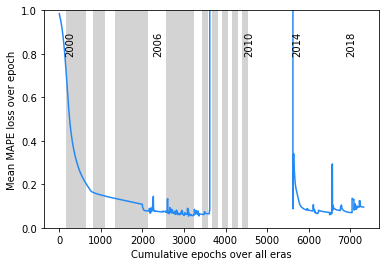

In [ ]:
plt.plot(losses["val"])

for (x1, _), (x2, _) in chunked(lines, n=2):
    plt.axvspan(xmin=x1, xmax=x2, color="lightgrey")

plt.text(150, 0.8, "2000", rotation="vertical")
plt.text(2250, 0.8, "2006", rotation="vertical")
plt.text(4450, 0.8, "2010", rotation="vertical")
plt.text(5600, 0.8, "2014", rotation="vertical")
plt.text(6900, 0.8, "2018", rotation="vertical")

plt.xlabel("Cumulative epochs over all eras")
plt.ylabel("Mean MAPE loss over epoch")
plt.ylim(top=1, bottom=0);

## Mean loss for each era

In [ ]:
date_range = pd.date_range(start="2000-12-31", end="2018-10-31", freq="M")
nums = [([d] * l) for d, l in zip(date_range, losses["epoch_lens"])]
flat = [item for sublist in nums for item in sublist]

In [ ]:
start = 0
months = []
val_loss = losses["val"]

for l, d in zip(losses["epoch_lens"], date_range):
    months.append(
        (d, np.mean(val_loss[start:start+l]))
    )
    start += l

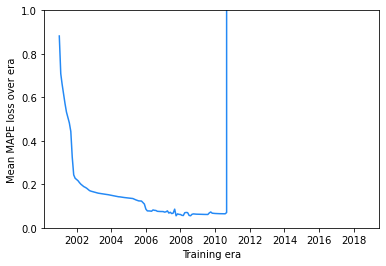

In [ ]:
plt.plot(*zip(*months))
plt.ylim(top=1, bottom=0)

plt.xlabel("Training era")
plt.ylabel("Mean MAPE loss over era");